# Forecast the difference between DAP and SSP
Author: George Panagiotou

In [2]:
import pandas as pd
import numpy as np
from comp_utils import *
import lightgbm as lgb
import os
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import make_scorer
import os
import lightgbm as lgb
import optuna
from sklearn.metrics import make_scorer
import numpy as np


## Load Train data:

In [3]:
Actual=pd.read_csv('data/TradingTrackData/Actual_quantiles_cv_set.csv')
Actual['time']=pd.to_datetime(Actual['time'])
Actual.rename(columns={'time':'valid_time'},inplace=True)

In [4]:
train_weather_feat = pd.read_hdf('data/DAP/train_features.h5', 'df')
columns_to_drop = [
    'SS_Price', 'DA_Price', 'total_generation_MWh', 'ND', 'TSD', 
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_SOLAR_GENERATION', 
    'EMBEDDED_SOLAR_CAPACITY', 'EMBEDDED_WIND_CAPACITY', 
    'PUMP_STORAGE_PUMPING', 'q10', 'q20', 'q30', 
    'q40', 'q50', 'q60', 'q70', 'q80', 'q90'
]
train_weather_feat = train_weather_feat.drop(columns=columns_to_drop)

demand_pred=pd.read_csv('data/TradingTrackData/Demand_quantiles_train_set.csv')
demand_pred.rename(columns={'time':'valid_time'}, inplace=True)
demand_pred['valid_time'] = pd.to_datetime(demand_pred['valid_time'], utc=True)
demand_pred.drop(['ND'], axis=1, inplace=True)

DAP_train_predictions=pd.read_csv('data/TradingTrackData/DAP_quantiles_train_set.csv')
DAP_train_predictions.rename(columns={'time':'valid_time'}, inplace=True)
DAP_train_predictions.drop(['DA_Price'], axis=1, inplace=True)
DAP_train_predictions['valid_time'] = pd.to_datetime(DAP_train_predictions['valid_time'], utc=True)

SSP_train_predictions=pd.read_csv('data/TradingTrackData/SSP_quantiles_train_set.csv')
SSP_train_predictions.rename(columns={'time':'valid_time'}, inplace=True)
SSP_train_predictions.drop(['SS_Price'], axis=1, inplace=True)
SSP_train_predictions['valid_time'] = pd.to_datetime(SSP_train_predictions['valid_time'], utc=True)

energy_data = pd.read_hdf("data/combined/train_energy_data_20200920_20240519.h5",'df')
train_table = pd.merge(demand_pred, train_weather_feat, on='valid_time', how='left')
train_table = pd.merge(train_table, energy_data, left_on='valid_time', right_on='dtm', how='left')
train_table = pd.merge(train_table, DAP_train_predictions, on='valid_time', how='left')
train_table = pd.merge(train_table, SSP_train_predictions, on='valid_time', how='left')
train_table.dropna(inplace=True)
train_table.drop_duplicates(subset='valid_time', inplace=True)

train_times = train_table['valid_time']
train_target_variable = train_table['DA_Price']-train_table['SS_Price']
train_table.drop(['DA_Price','dtm', 'MIP', 'Solar_installedcapacity_mwp', 'Solar_MW', 'Solar_capacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh', 'Availability1', 'Availability2', 'Availability3',], axis=1, inplace=True)
print(train_table.shape)

print("Original Train Table Shape:", train_table.shape)

(43906, 99)
Original Train Table Shape: (43906, 99)


In [5]:
train_weather_feat = pd.read_hdf('data/DAP/train_features.h5', 'df')
columns_to_drop = [
    'SS_Price', 'DA_Price', 'total_generation_MWh', 'ND', 'TSD', 
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_SOLAR_GENERATION', 
    'EMBEDDED_SOLAR_CAPACITY', 'EMBEDDED_WIND_CAPACITY', 
    'PUMP_STORAGE_PUMPING', 'q10', 'q20', 'q30', 
    'q40', 'q50', 'q60', 'q70', 'q80', 'q90'
]
train_weather_feat = train_weather_feat.drop(columns=columns_to_drop)

demand_pred=pd.read_csv('data/TradingTrackData/Demand_quantiles_cv_set.csv')
demand_pred.rename(columns={'time':'valid_time'}, inplace=True)
demand_pred['valid_time'] = pd.to_datetime(demand_pred['valid_time'], utc=True)
demand_pred.drop(['ND'], axis=1, inplace=True)

DAP_cv_predictions=pd.read_csv('data/TradingTrackData/DAP_quantiles_cv_set.csv')
DAP_cv_predictions.rename(columns={'time':'valid_time'}, inplace=True)
DAP_cv_predictions['valid_time'] = pd.to_datetime(DAP_cv_predictions['valid_time'], utc=True)
DAP_cv_predictions.drop(['DA_Price'], axis=1, inplace=True)

SSP_cv_predictions=pd.read_csv('data/TradingTrackData/SSP_quantiles_cv_set.csv')
SSP_cv_predictions.rename(columns={'time':'valid_time'}, inplace=True)
SSP_cv_predictions['valid_time'] = pd.to_datetime(SSP_cv_predictions['valid_time'], utc=True)
SSP_cv_predictions.drop(['SS_Price'], axis=1, inplace=True)

energy_data = pd.read_hdf("data/combined/train_energy_data_20200920_20240519.h5",'df')
cv_table = pd.merge(demand_pred, train_weather_feat, on='valid_time', how='left')
cv_table = pd.merge(cv_table, energy_data, left_on='valid_time', right_on='dtm', how='left')
cv_table = pd.merge(cv_table, DAP_cv_predictions, on='valid_time', how='left')
cv_table = pd.merge(cv_table, SSP_cv_predictions, on='valid_time', how='left')
cv_table.dropna(inplace=True)

cv_times = cv_table['valid_time']
cv_target_variable = cv_table['DA_Price']-cv_table['SS_Price']
cv_table.drop(['DA_Price','dtm', 'MIP', 'Solar_installedcapacity_mwp', 'Solar_MW', 'Solar_capacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh', 'Availability1', 'Availability2', 'Availability3',], axis=1, inplace=True)
print(cv_table.shape)
print("CV Set Shape:", cv_table.shape)

(5615, 99)
CV Set Shape: (5615, 99)


In [6]:
test_weather_feat = pd.read_hdf('data/DAP/test_features.h5', 'df')
columns_to_drop = [
    'SS_Price', 'DA_Price', 'total_generation_MWh', 'ND', 'TSD', 
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_SOLAR_GENERATION', 
    'EMBEDDED_SOLAR_CAPACITY', 'EMBEDDED_WIND_CAPACITY', 
    'PUMP_STORAGE_PUMPING', 'q10', 'q20', 'q30', 
    'q40', 'q50', 'q60', 'q70', 'q80', 'q90'
]
test_weather_feat = test_weather_feat.drop(columns=columns_to_drop)

demand_pred_test = pd.read_csv('data/Demand/Demand_predictions_test_set.csv')
demand_pred_test.rename(columns={'time':'valid_time'}, inplace=True)
demand_pred_test['valid_time'] = pd.to_datetime(demand_pred_test['valid_time'], utc=True)
demand_pred_test.drop(['ND'], axis=1, inplace=True)
print(demand_pred_test.shape)

DAP_train_predictions=pd.read_csv('data/TradingTrackData/DAP_quantiles_test_set.csv')
DAP_train_predictions.rename(columns={'time':'valid_time'}, inplace=True)
DAP_train_predictions.drop(['DA_Price'], axis=1, inplace=True)
DAP_train_predictions['valid_time'] = pd.to_datetime(DAP_train_predictions['valid_time'], utc=True)

SSP_train_predictions=pd.read_csv('data/TradingTrackData/SSP_quantiles_test_set.csv')
SSP_train_predictions.rename(columns={'time':'valid_time'}, inplace=True)
SSP_train_predictions.drop(['SS_Price'], axis=1, inplace=True)
SSP_train_predictions['valid_time'] = pd.to_datetime(SSP_train_predictions['valid_time'], utc=True)

energy_data_test = pd.read_hdf("data/combined/test_energy_data_20200920_20240519.h5",'df')

test_table = pd.merge(demand_pred_test, test_weather_feat, on='valid_time', how='left')
test_table = pd.merge(test_table, energy_data_test, left_on='valid_time', right_on='dtm', how='left')
test_table = pd.merge(test_table, DAP_train_predictions, on='valid_time', how='left')
test_table = pd.merge(test_table, SSP_train_predictions, on='valid_time', how='left')
test_table.fillna(test_table.mean(), inplace=True)

test_times = test_table['valid_time']
test_target_variable = test_table['DA_Price']-test_table['SS_Price']
test_table.drop(['DA_Price','dtm', 'MIP', 'Solar_installedcapacity_mwp', 'Solar_MW', 'Solar_capacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh', 'Availability1', 'Availability2', 'Availability3',], axis=1, inplace=True)
print(test_table.columns)

(4318, 10)
Index(['q10_x', 'q20_x', 'q30_x', 'q40_x', 'q50_x', 'q60_x', 'q70_x', 'q80_x',
       'q90_x', 'valid_time', 'DWD_WS_D_0', 'DWD_WS_D_1', 'DWD_WS_D_2',
       'DWD_WS_D_3', 'DWD_WS_D_4', 'DWD_WS_D_5', 'DWD_WS_D_6', 'DWD_WD_D_0',
       'DWD_WD_D_1', 'DWD_WD_D_2', 'DWD_WD_D_3', 'DWD_WD_D_4', 'DWD_WD_D_5',
       'DWD_WD_D_6', 'DWD_RH_D_0', 'DWD_RH_D_1', 'DWD_RH_D_2', 'DWD_RH_D_3',
       'DWD_RH_D_4', 'DWD_RH_D_5', 'DWD_RH_D_6', 'DWD_T_D_0', 'DWD_T_D_1',
       'DWD_T_D_2', 'DWD_T_D_3', 'DWD_T_D_4', 'DWD_T_D_5', 'DWD_T_D_6',
       'DWD_TP_D_0', 'DWD_TP_D_1', 'DWD_TP_D_2', 'DWD_TP_D_3', 'DWD_TP_D_4',
       'DWD_TP_D_5', 'DWD_TP_D_6', 'NCEP_WS_D_0', 'NCEP_WS_D_1', 'NCEP_WS_D_2',
       'NCEP_WS_D_3', 'NCEP_WS_D_4', 'NCEP_WS_D_5', 'NCEP_WS_D_6',
       'NCEP_WD_D_0', 'NCEP_WD_D_1', 'NCEP_WD_D_2', 'NCEP_WD_D_3',
       'NCEP_WD_D_4', 'NCEP_WD_D_5', 'NCEP_WD_D_6', 'NCEP_RH_D_0',
       'NCEP_RH_D_1', 'NCEP_RH_D_2', 'NCEP_RH_D_3', 'NCEP_RH_D_4',
       'NCEP_RH_D_5', 'NCEP_RH_D_6'

## Transforming time into cyclic features:
We need to transform UTC datetime feature into numbers, thus we choose to convert datetime to cyclic features 

In [7]:
train_table = add_cyclic_features(train_table)
train_table = train_table.drop(columns=["valid_time"])
print('Train features after adding cyclic times and removing valid_time:', train_table.shape)

cv_table = add_cyclic_features(cv_table)
cv_table = cv_table.drop(columns=["valid_time"])
print('CV features after adding cyclic times and removing valid_time:', cv_table.shape)

test_table = add_cyclic_features(test_table)
test_table = test_table.drop(columns=["valid_time"])
print('Test features after adding cyclic times and removing valid_time:', test_table.shape)

Train features after adding cyclic times and removing valid_time: (43906, 107)
CV features after adding cyclic times and removing valid_time: (5615, 107)
Test features after adding cyclic times and removing valid_time: (4318, 107)


In [22]:
# Directory for saving models
saved_models_dir = 'models/DAP'
os.makedirs(saved_models_dir, exist_ok=True)

# Quantiles for the models
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_params_dict = {}
best_models = {}

# Function to compute pinball loss
def pinball_loss(y_true, y_pred, alpha):
    residuals = y_true - y_pred
    return np.mean(np.maximum(alpha * residuals, (alpha - 1) * residuals))

# Objective function for Optuna
def objective(trial, quantile, initial_params=None):
    if initial_params:
        params = initial_params
    else:
        params = {
            'objective': 'quantile',
            'alpha': quantile,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            'max_depth': trial.suggest_int('max_depth', -7, 7),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e3, log=True),
            'verbose': -1
        }

    model = lgb.LGBMRegressor(**params)

    # Train on train_table and evaluate on cv_table
    model.fit(train_table, train_target_variable)
    preds = model.predict(cv_table)
    
    # Calculate pinball loss on the CV set
    loss = pinball_loss(cv_target_variable, preds, alpha=quantile)
    
    return loss

# Train a model for each quantile with Optuna
for quantile in quantiles:
    print(f"Starting optimization for quantile {quantile}")
    study = optuna.create_study(direction='minimize')
    
    # Initial parameters (from the ones you provided)
    initial_params = {
        'objective': 'quantile',
        'alpha': quantile,
        'learning_rate': 0.1,
        'max_depth': -4,
        'n_estimators': 150,
        'num_leaves': 60,
        'min_child_weight': 1e-2,
        'verbose': -1
    }
    
    # Run the first trial with your initial parameters
    study.enqueue_trial(initial_params)
    
    # Run further trials
    study.optimize(lambda trial: objective(trial, quantile), n_trials=50)  # You can adjust the number of trials
    
    best_params = study.best_params
    best_params['objective'] = 'quantile'
    best_params['alpha'] = quantile
    
    # Train the model with the best parameters
    model = lgb.LGBMRegressor(**best_params)
    model.fit(
        train_table, train_target_variable,
        eval_set=[(cv_table, cv_target_variable)],
        eval_metric='quantile'
    )
    
    # Save the model
    model_path = f'{saved_models_dir}/DASS_Tuned_q{int(quantile * 100)}.txt'
    model.booster_.save_model(model_path)
    
    # Store the best params and model
    best_params_dict[quantile] = best_params
    best_models[quantile] = model
    
    print(f"Finished optimization for quantile {quantile}")
    print(f"Best parameters for quantile {quantile}: {best_params}")

# Print the last training loss for each quantile after all models have been trained
for quantile, model in best_models.items():
    last_loss = model.evals_result_['valid_0']['quantile'][-1]
    print(f"Last CV loss for quantile {quantile}: {last_loss}")

[I 2024-08-20 22:49:46,858] A new study created in memory with name: no-name-f9b9bdb9-df81-42f2-8c3c-ad254b7ea3e7


Starting optimization for quantile 0.1


[I 2024-08-20 22:49:47,909] Trial 0 finished with value: 8.613289121587432 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 8.613289121587432.
[I 2024-08-20 22:49:49,601] Trial 1 finished with value: 7.759936579611473 and parameters: {'learning_rate': 0.030039546489421223, 'max_depth': -7, 'n_estimators': 189, 'num_leaves': 83, 'min_child_weight': 352.3487991282488}. Best is trial 1 with value: 7.759936579611473.
[I 2024-08-20 22:49:50,532] Trial 2 finished with value: 8.039947645069622 and parameters: {'learning_rate': 0.04231050945002233, 'max_depth': -3, 'n_estimators': 159, 'num_leaves': 50, 'min_child_weight': 2.821547792117847}. Best is trial 1 with value: 7.759936579611473.
[I 2024-08-20 22:49:51,265] Trial 3 finished with value: 8.508344699939057 and parameters: {'learning_rate': 0.07739518610306069, 'max_depth': -3, 'n_estimators': 201, 'num_leaves': 23, 'min_child_weight': 1.3

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24863
[LightGBM] [Info] Number of data points in the train set: 43906, number of used features: 107
[LightGBM] [Info] Start training from score -62.134998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-08-20 22:50:18,529] A new study created in memory with name: no-name-a76b2519-af0a-429c-afae-eb920b5be9c8


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-20 22:50:19,499] Trial 0 finished with value: 12.029669494729848 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 12.029669494729848.
[I 2024-08-20 22:50:19,719] Trial 1 finished with value: 11.650202532985052 and parameters: {'learning_rate': 0.0132931409149161, 'max_depth': 4, 'n_estimators': 57, 'num_leaves': 87, 'min_child_weight': 0.0035740044378413513}. Best is trial 1 with value: 11.650202532985052.
[I 2024-08-20 22:50:20,530] Trial 2 finished with value: 11.924541065289096 and parameters: {'learning_rate': 0.1359219086466172, 'max_depth': 7, 'n_estimators': 142, 'num_leaves': 77, 'min_child_weight': 4.083417277105759}. Best is trial 1 with value: 11.650202532985052.
[I 2024-08-20 22:50:22,042] Trial 3 finished with value: 12.047243567175956 and parameters: {'learning_rate': 0.06542845308361667, 'max_depth': -4, 'n_estimators': 190, 'num_leaves': 70, 'min_child_weight'

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24863
[LightGBM] [Info] Number of data points in the train set: 43906, number of used features: 107
[LightGBM] [Info] Start training from score -39.060001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-08-20 22:50:58,370] A new study created in memory with name: no-name-dd0e564d-324c-4d7d-a13d-fd2c4fa232c8


Finished optimization for quantile 0.2
Best parameters for quantile 0.2: {'learning_rate': 0.022973594981773045, 'max_depth': 6, 'n_estimators': 118, 'num_leaves': 66, 'min_child_weight': 0.2060953359902168, 'objective': 'quantile', 'alpha': 0.2}
Starting optimization for quantile 0.3


[I 2024-08-20 22:50:59,368] Trial 0 finished with value: 14.004421624016393 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 14.004421624016393.
[I 2024-08-20 22:51:00,090] Trial 1 finished with value: 14.201041067409738 and parameters: {'learning_rate': 0.10474591851992678, 'max_depth': 6, 'n_estimators': 222, 'num_leaves': 22, 'min_child_weight': 4.138485164765027}. Best is trial 0 with value: 14.004421624016393.
[I 2024-08-20 22:51:00,709] Trial 2 finished with value: 13.818772889939376 and parameters: {'learning_rate': 0.09605314657904916, 'max_depth': -4, 'n_estimators': 52, 'num_leaves': 99, 'min_child_weight': 37.11392186736983}. Best is trial 2 with value: 13.818772889939376.
[I 2024-08-20 22:51:02,051] Trial 3 finished with value: 14.011682167870491 and parameters: {'learning_rate': 0.05948043621178618, 'max_depth': -2, 'n_estimators': 226, 'num_leaves': 50, 'min_child_weight':

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24863
[LightGBM] [Info] Number of data points in the train set: 43906, number of used features: 107
[LightGBM] [Info] Start training from score -25.070000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-08-20 22:52:03,403] A new study created in memory with name: no-name-752a4ce8-ebeb-407f-85f6-f1aacca00def


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-20 22:52:04,428] Trial 0 finished with value: 14.962516316813058 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 14.962516316813058.
[I 2024-08-20 22:52:05,843] Trial 1 finished with value: 14.918215167179138 and parameters: {'learning_rate': 0.016828036015074644, 'max_depth': -4, 'n_estimators': 276, 'num_leaves': 40, 'min_child_weight': 692.5481988650308}. Best is trial 1 with value: 14.918215167179138.
[I 2024-08-20 22:52:06,258] Trial 2 finished with value: 15.431603492828755 and parameters: {'learning_rate': 0.016772392008403903, 'max_depth': -6, 'n_estimators': 72, 'num_leaves': 35, 'min_child_weight': 0.17905949337494032}. Best is trial 1 with value: 14.918215167179138.
[I 2024-08-20 22:52:07,536] Trial 3 finished with value: 14.821232866449147 and parameters: {'learning_rate': 0.0298940296762154, 'max_depth': -2, 'n_estimators': 153, 'num_leaves': 73, 'min_child_weig

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24863
[LightGBM] [Info] Number of data points in the train set: 43906, number of used features: 107
[LightGBM] [Info] Start training from score -15.210000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[I 2024-08-20 22:52:59,063] A new study created in memory with name: no-name-53e359aa-b8cb-4756-bc33-84e5f6ba58be


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-20 22:53:00,064] Trial 0 finished with value: 15.082289585319067 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 15.082289585319067.
[I 2024-08-20 22:53:00,285] Trial 1 finished with value: 15.157503515848875 and parameters: {'learning_rate': 0.04355989491509264, 'max_depth': 4, 'n_estimators': 55, 'num_leaves': 47, 'min_child_weight': 0.23469424828834948}. Best is trial 0 with value: 15.082289585319067.
[I 2024-08-20 22:53:01,113] Trial 2 finished with value: 14.877584073255365 and parameters: {'learning_rate': 0.02313141349550808, 'max_depth': -4, 'n_estimators': 134, 'num_leaves': 50, 'min_child_weight': 114.79667287157966}. Best is trial 2 with value: 14.877584073255365.
[I 2024-08-20 22:53:01,576] Trial 3 finished with value: 15.093490324969725 and parameters: {'learning_rate': 0.038889212409656426, 'max_depth': 3, 'n_estimators': 208, 'num_leaves': 60, 'min_child_weigh

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24863
[LightGBM] [Info] Number of data points in the train set: 43906, number of used features: 107
[LightGBM] [Info] Start training from score -1.045065


[I 2024-08-20 22:54:42,594] A new study created in memory with name: no-name-cbdc4065-6ee8-4a97-bcb5-0687fc5a29c3


Finished optimization for quantile 0.5
Best parameters for quantile 0.5: {'learning_rate': 0.011344349142377447, 'max_depth': -7, 'n_estimators': 273, 'num_leaves': 100, 'min_child_weight': 0.002160989068218634, 'objective': 'quantile', 'alpha': 0.5}
Starting optimization for quantile 0.6


[I 2024-08-20 22:54:43,623] Trial 0 finished with value: 14.266255308673873 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 14.266255308673873.
[I 2024-08-20 22:54:45,049] Trial 1 finished with value: 14.205159499122246 and parameters: {'learning_rate': 0.08207180648200955, 'max_depth': -1, 'n_estimators': 155, 'num_leaves': 84, 'min_child_weight': 49.99523875444}. Best is trial 1 with value: 14.205159499122246.
[I 2024-08-20 22:54:46,531] Trial 2 finished with value: 14.265273587710968 and parameters: {'learning_rate': 0.019587116600088456, 'max_depth': -4, 'n_estimators': 165, 'num_leaves': 79, 'min_child_weight': 0.006841890849599187}. Best is trial 1 with value: 14.205159499122246.
[I 2024-08-20 22:54:47,119] Trial 3 finished with value: 14.544994001100484 and parameters: {'learning_rate': 0.014797519943230726, 'max_depth': -3, 'n_estimators': 94, 'num_leaves': 44, 'min_child_weigh

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24863
[LightGBM] [Info] Number of data points in the train set: 43906, number of used features: 107
[LightGBM] [Info] Start training from score 15.300011


[I 2024-08-20 22:55:28,434] A new study created in memory with name: no-name-de5e69e5-6dac-44f9-b789-f67569513350


Finished optimization for quantile 0.6
Best parameters for quantile 0.6: {'learning_rate': 0.07372475088656313, 'max_depth': 7, 'n_estimators': 265, 'num_leaves': 32, 'min_child_weight': 0.0023732671035589467, 'objective': 'quantile', 'alpha': 0.6}
Starting optimization for quantile 0.7


[I 2024-08-20 22:55:29,479] Trial 0 finished with value: 12.861239099329934 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 12.861239099329934.
[I 2024-08-20 22:55:29,844] Trial 1 finished with value: 12.86904076985223 and parameters: {'learning_rate': 0.11401157332381615, 'max_depth': 1, 'n_estimators': 196, 'num_leaves': 69, 'min_child_weight': 154.2992768563449}. Best is trial 0 with value: 12.861239099329934.
[I 2024-08-20 22:55:30,301] Trial 2 finished with value: 12.860363460333263 and parameters: {'learning_rate': 0.0745442512124204, 'max_depth': -6, 'n_estimators': 55, 'num_leaves': 61, 'min_child_weight': 34.23423726083658}. Best is trial 2 with value: 12.860363460333263.
[I 2024-08-20 22:55:30,476] Trial 3 finished with value: 15.188611784010327 and parameters: {'learning_rate': 0.011104570918459615, 'max_depth': 1, 'n_estimators': 53, 'num_leaves': 54, 'min_child_weight': 13

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24863
[LightGBM] [Info] Number of data points in the train set: 43906, number of used features: 107
[LightGBM] [Info] Start training from score 29.510000


[I 2024-08-20 22:56:46,531] A new study created in memory with name: no-name-c6541272-2607-4faf-95c7-0e1ce8881e84


Finished optimization for quantile 0.7
Best parameters for quantile 0.7: {'learning_rate': 0.08269958816586145, 'max_depth': -6, 'n_estimators': 199, 'num_leaves': 95, 'min_child_weight': 20.121004472302893, 'objective': 'quantile', 'alpha': 0.7}
Starting optimization for quantile 0.8


[I 2024-08-20 22:56:47,548] Trial 0 finished with value: 10.515008506095658 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 10.515008506095658.
[I 2024-08-20 22:56:48,024] Trial 1 finished with value: 10.539041468377071 and parameters: {'learning_rate': 0.12602401980692945, 'max_depth': 6, 'n_estimators': 97, 'num_leaves': 75, 'min_child_weight': 0.001034054586409475}. Best is trial 0 with value: 10.515008506095658.
[I 2024-08-20 22:56:50,202] Trial 2 finished with value: 10.33282939977197 and parameters: {'learning_rate': 0.07105200322510033, 'max_depth': -2, 'n_estimators': 229, 'num_leaves': 97, 'min_child_weight': 0.7240698533113}. Best is trial 2 with value: 10.33282939977197.
[I 2024-08-20 22:56:51,518] Trial 3 finished with value: 10.403414403312096 and parameters: {'learning_rate': 0.01032852924019552, 'max_depth': -1, 'n_estimators': 218, 'num_leaves': 47, 'min_child_weight': 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24863
[LightGBM] [Info] Number of data points in the train set: 43906, number of used features: 107
[LightGBM] [Info] Start training from score 47.090004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-08-20 22:57:51,285] A new study created in memory with name: no-name-eb899c23-f4ea-4c9e-a832-d786c302cc15


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-20 22:57:52,252] Trial 0 finished with value: 6.790076667062589 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 6.790076667062589.
[I 2024-08-20 22:57:52,578] Trial 1 finished with value: 6.873680006648543 and parameters: {'learning_rate': 0.010178607954250936, 'max_depth': 3, 'n_estimators': 156, 'num_leaves': 94, 'min_child_weight': 149.4401417724866}. Best is trial 0 with value: 6.790076667062589.
[I 2024-08-20 22:57:52,781] Trial 2 finished with value: 8.127920441847385 and parameters: {'learning_rate': 0.012011926413271142, 'max_depth': 1, 'n_estimators': 70, 'num_leaves': 30, 'min_child_weight': 704.8093115447183}. Best is trial 0 with value: 6.790076667062589.
[I 2024-08-20 22:57:53,119] Trial 3 finished with value: 6.559260599767328 and parameters: {'learning_rate': 0.01593961001086031, 'max_depth': 3, 'n_estimators': 168, 'num_leaves': 39, 'min_child_weight': 6.7762

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24863
[LightGBM] [Info] Number of data points in the train set: 43906, number of used features: 107
[LightGBM] [Info] Start training from score 74.910004
Finished optimization for quantile 0.9
Best parameters for quantile 0.9: {'learning_rate': 0.01061321502490367, 'max_depth': -5, 'n_estimators': 264, 'num_leaves': 43, 'min_child_weight': 0.004124348240572179, 'objective': 'quantile', 'alpha': 0.9}
Last CV loss for quantile 0.1: 6.780581668037305
Last CV loss for quantile 0.2: 11.061610703172434
Last CV loss for quantile 0.3: 13.33870378623958
Last CV loss for quantile 0.4: 14.65918709643453
Last CV loss for quantile 0.5: 14.761340830757305
Last CV loss for quantile 0.6: 14.126759588916896
Last CV loss for quantile 0.7: 12.67027454288016
Last CV loss for quantile 0.8: 10.31084062314175
Last CV los

In [9]:
quantile_predictions = {}
quantile_predictions['DASS'] = train_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/DAP/DASS_Tuned_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(train_table)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)
print(pinball_score(quantile_predictions_df,target_col='DASS'))

# Save the predictions (They might be used for ensemble learning)
quantile_predictions_df['time'] = train_times  
quantile_predictions_df.to_csv('data/TradingTrackData/DASS_train_set.csv', index=False)

7.946356082387325


In [10]:
quantile_predictions = {}
quantile_predictions['DASS'] = cv_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/DAP/DASS_Tuned_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(cv_table)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)
print(pinball_score(quantile_predictions_df,target_col='DASS'))

quantile_predictions_df['time'] = cv_times  
quantile_predictions_df.to_csv('data/TradingTrackData/DASS_cv_set.csv', index=False)

11.526005750545346


In [11]:
quantile_predictions = {}
quantile_predictions['DASS'] = test_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/DAP/DASS_Tuned_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(test_table)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)
print(pinball_score(quantile_predictions_df,target_col='DASS'))

quantile_predictions_df['time'] = test_times  
quantile_predictions_df.to_csv('data/TradingTrackData/DASS_test_set.csv', index=False)


9.237183999525646


In [12]:
save_path = "plots/DAP/DASS_Plot.html"
graph_title = "DAP-SSP Quantile Predictions"
quantile_predictions_df['time'] = test_times  
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'DASS', test_times, save_path, title=graph_title)

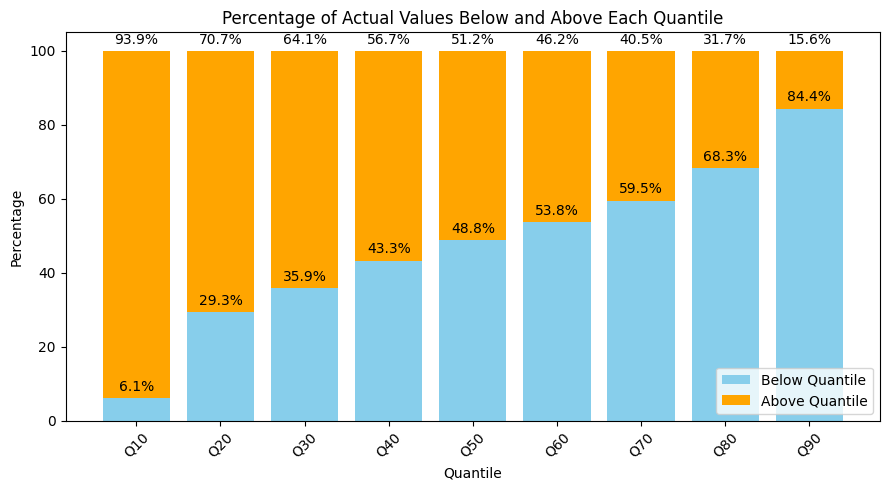

In [13]:
quantile_stats(quantile_predictions_df,'DASS')